# Análise Exploratória e Previsão de Jogos da NBA

# Objetivo

* Este projeto visa primeiramente realizar uma análise exploratória dos dados obtidos das últimas 6 temporadas regulares da NBA (2017-18 a 2022-23) e treinar uma rede neural com o intuito de prever-se o time vencedor de uma partida.

# Obtenção e manipulação dos dados

* Os dados foram obtidos através da API da NBA, o script 'get_team_stats.py' obtém as médias estatísticas de todos os times após cada jogo da temporada regular das úlitmas 6 temporadas (2017-18 a 2022-23). Ele pode ser oncontrato em:

    - (https://github.com/ArthurPatricio/Final_Project_Basketball_Game_Prediction/blob/main/get_team_stats.py)
* O script 'get_games.py' obtém a lista de todos os jogos das últimas 6 temporadas regulares (2017-18 a 2022-23). Ele pode ser encontrado em:

    - (https://github.com/ArthurPatricio/Final_Project_Basketball_Game_Prediction/blob/main/get_games.py)

* O script 'organize_data.py' tem os dados dados proveninetes dos 2 scripts anteriores e como suas entradas. Este script reorganiza os dados de forma que cada linha do dataframe seja única, contendo uma das partidas das últimas 6 temporadas regulares do conjunto. Colunas auxiliares foram craidas indicando o número do jogo dentro da temporada para cada time no confronto, por exemplo, um confronto pode uma partida entre de número 50 de um time A na temporada 2022-23 e a partida 48 de um time B que ele enfrenta neste confronto. 

* Os dados também foram trbalhados de forma que foram associados a cada confronto as médias estatísticas dos times. A associação é feita da seguinte forma, para cada confronto cada time recebe as sua médias estatísticas até o momento daquele jogo. Expandindo o exemplo anterior, no confronto entre os times A e B, A irá jogar sua partida de número 50, então chegara com as médias das 49 partidas anteriores a este jogo, já o time B, chegará com as médias das 47 partidas que já jogou na temporada. O script pode ser encontrado em:

    - (https://github.com/ArthurPatricio/Final_Project_Basketball_Game_Prediction/blob/main/organize_data.py)

* O último script, 'final_data.py', realiza a mesclagem final dos dados, unindo os confrontos às médias estatísticas do par de times até aquele momento (jogo) da temporada. Os dados são salvos em planilha, chamada 'nba_data.xlsx'. Ele pode ser encontrado em:

    - (https://github.com/ArthurPatricio/Final_Project_Basketball_Game_Prediction/blob/main/final_data.py)

# Linguagem, Bibliotecas e Pacotes

O trabalho foi feito todo em Python 3. Abaixo, segue a listagem de todas bibliotecas e pacotes utilizados:

In [670]:
# Import libs

import numpy as np
import pandas as pd
import missingno as msno
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import tensorflow_addons as tfa

# Leitura dos Dados

A planilha 'nba_data.xlsx' foi importada e inserida em um Dataframe utilizando a biblioteca pandas.

In [671]:
# Read NBA data from excel file

nba_data = pd.read_excel('nba_data.xlsx')

O dataframe tem a coluna 'Unnamed: 0' retirada.

In [672]:
# Drop "Unnamed: 0" column

nba_data.drop(['Unnamed: 0'], axis=1, inplace=True)

# Análise Inicial

O dataset possui 6963 registros e 132 atributos.

In [673]:
# Get nba_data dataframa shape

nba_data.shape

(6963, 132)

In [674]:
# Get nba_data dataframe columns

nba_data.columns

Index(['HOME_TEAM_ID', 'HOME_TEAM_ABBREVIATION', 'HOME_GAME_ID',
       'HOME_MATCHUP', 'HOME_SEASON', 'HOME_GAME_N', 'HOME_WL', 'AWAY_TEAM_ID',
       'AWAY_TEAM_ABBREVIATION', 'AWAY_GAME_ID',
       ...
       'BLK_RANK_y', 'BLKA_RANK_y', 'PF_RANK_y', 'PFD_RANK_y', 'PTS_RANK_y',
       'PLUS_MINUS_RANK_y', 'GAME_DATE_y', 'SEASON_y', 'GAME_N_y',
       'COMPARE_y'],
      dtype='object', length=132)

In [675]:
# Get nba_data dataframe describe

nba_data.describe()

,HOME_TEAM_ID,HOME_GAME_ID,HOME_GAME_N,AWAY_TEAM_ID,AWAY_GAME_ID,AWAY_GAME_N,TEAM_ID_x,GP_x,W_x,L_x,...,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y,GAME_N_y
count,6.963000e+03,6.963000e+03,6963.000000,6.963000e+03,6.963000e+03,6963.000000,6.963000e+03,6963.000000,6963.000000,6963.000000,...,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000
mean,1.610613e+09,2.195075e+07,40.421657,1.610613e+09,2.195075e+07,40.431567,1.610613e+09,39.421657,19.688640,19.733017,...,15.345541,15.321844,15.419647,15.286514,15.244004,15.371248,15.439466,15.327876,15.286227,40.431567
std,8.653343e+00,1.743568e+05,22.634354,8.640874e+00,1.743568e+05,22.614953,8.653343e+00,22.634354,13.039842,13.080083,...,8.664255,8.648501,8.662756,8.643116,8.639085,8.656732,8.616650,8.637555,8.633215,22.614953
min,1.610613e+09,2.170002e+07,2.000000,1.610613e+09,2.170002e+07,2.000000,1.610613e+09,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,1.610613e+09,2.180054e+07,21.000000,1.610613e+09,2.180054e+07,21.000000,1.610613e+09,20.000000,9.000000,9.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,21.000000
50%,1.610613e+09,2.200003e+07,40.000000,1.610613e+09,2.200003e+07,40.000000,1.610613e+09,39.000000,18.000000,18.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,16.000000,15.000000,15.000000,40.000000
75%,1.610613e+09,2.210070e+07,60.000000,1.610613e+09,2.210070e+07,60.000000,1.610613e+09,59.000000,29.000000,29.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,60.000000
max,1.610613e+09,2.220123e+07,82.000000,1.610613e+09,2.220123e+07,82.000000,1.610613e+09,81.000000,64.000000,64.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,82.000000


In [676]:
# Get classes

nba_data['HOME_WL'].value_counts()

HOME_WL
W    3936
L    3027
Name: count, dtype: int64

In [677]:
# Get nba_data dataframe info

nba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6963 entries, 0 to 6962
Columns: 132 entries, HOME_TEAM_ID to COMPARE_y
dtypes: float64(46), int64(68), object(18)
memory usage: 7.0+ MB


# Chegagem de valores nulos

nba_data não possui nenhum valor faltante.

Foi utilizado a biblioteca missingno para realizar a checagem.

<Axes: >

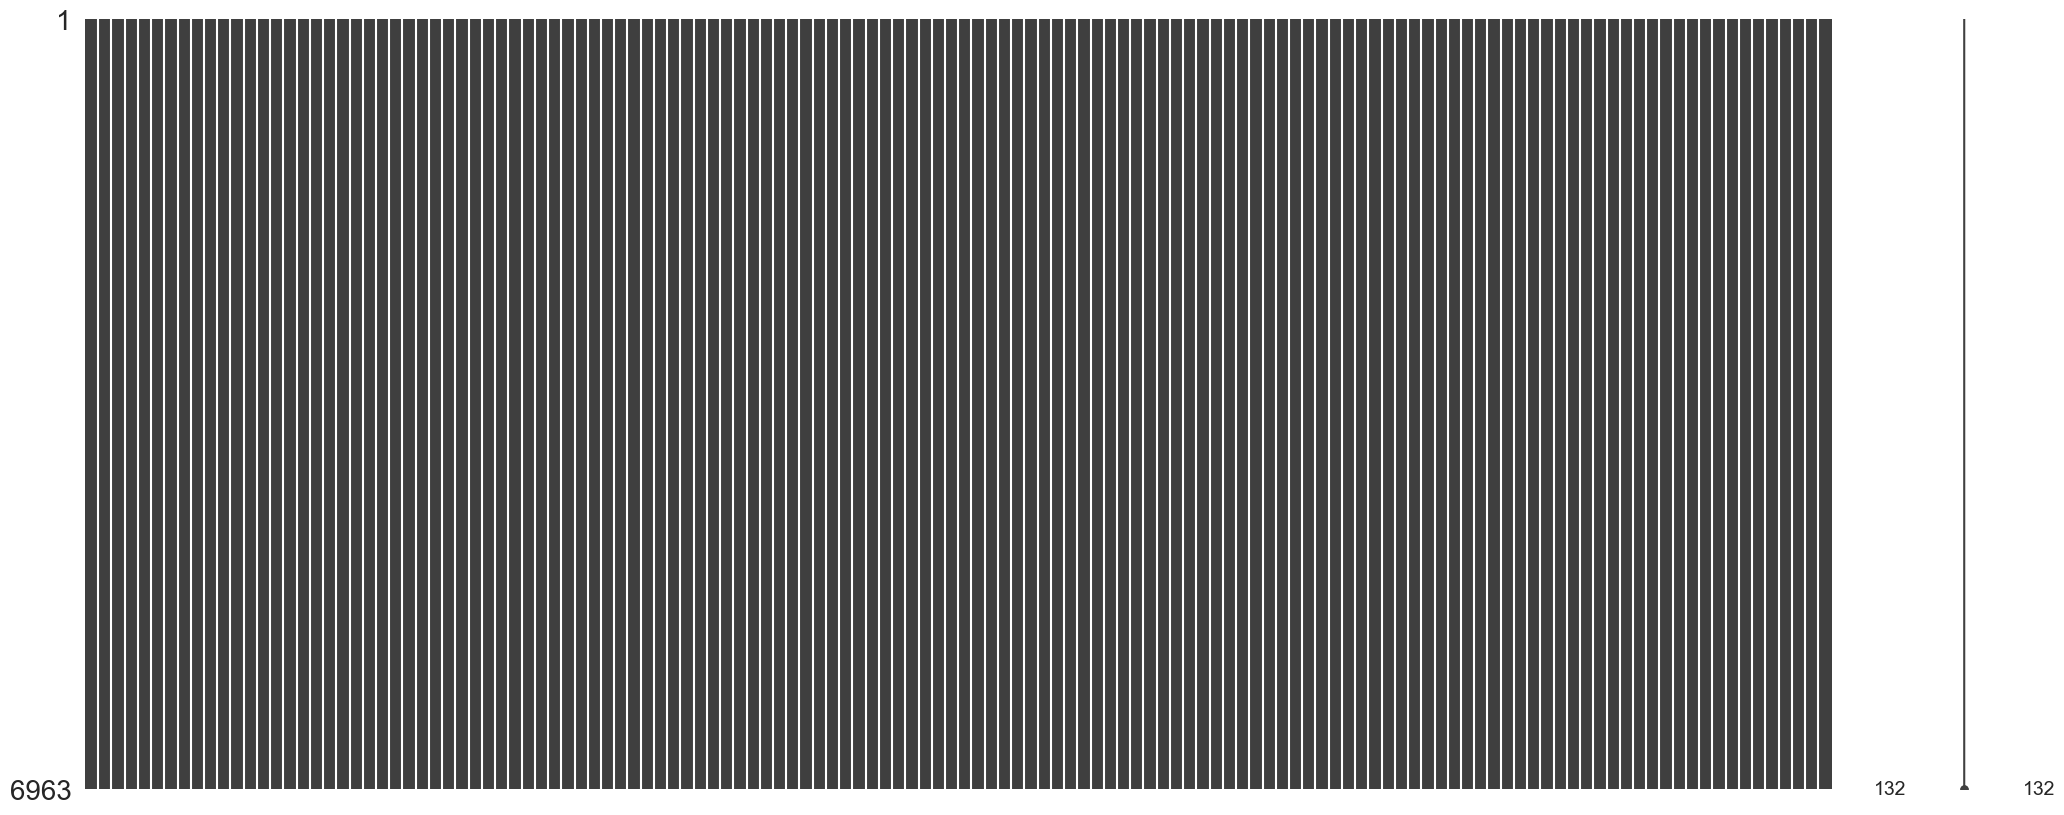

In [678]:
msno.matrix(nba_data)

# Relatório Pandas Profile

Foi gerado o 'Pandas Profile Report' que oferece uma análise extensa do conjunto de dados que está sendo abordado.

In [679]:
# Generate and export as a .html file the Pandas Profile Report of the nba_shots dataframe

#profile_data = ProfileReport(nba_data, title ='nba_data')
#profile_data.to_file("nba_data_pandas_profile_report.html")

In [680]:
# Show Profile Report in this notebook

#profile_data.to_notebook_iframe()

# Análise Exploratória


# 1. Vitórias e Derrotas por Time

In [681]:
# Number of games per season

nba_data['HOME_SEASON'].value_counts()

HOME_SEASON
2022-23    1214
2021-22    1214
2018-19    1214
2017-18    1214
2020-21    1064
2019-20    1043
Name: count, dtype: int64

In [682]:
nba_data[nba_data['HOME_SEASON'] == '2022-23']['HOME_WL']

0       W
1       W
2       W
3       L
4       W
       ..
6905    W
6941    W
6942    W
6943    W
6944    L
Name: HOME_WL, Length: 1214, dtype: object

In [683]:
nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'WAS') & (nba_data['HOME_SEASON'] == '2022-23')]['HOME_WL']

0     W
2     W
3     L
5     L
7     L
10    W
11    W
12    W
13    L
14    W
15    W
19    W
22    L
25    L
26    L
33    W
34    W
39    L
40    W
41    L
42    L
44    W
49    L
51    L
52    W
53    W
57    L
60    W
61    L
62    L
64    L
65    L
67    W
69    L
71    L
72    W
74    W
75    L
77    L
79    W
80    L
Name: HOME_WL, dtype: object

In [684]:
nba_data[nba_data['HOME_WL'] == 'W']['HOME_TEAM_ABBREVIATION'].value_counts().index

Index(['DEN', 'MIL', 'PHI', 'BOS', 'UTA', 'TOR', 'GSW', 'MIA', 'LAC', 'MEM',
       'POR', 'LAL', 'DAL', 'BKN', 'IND', 'SAS', 'HOU', 'NOP', 'OKC', 'PHX',
       'MIN', 'ATL', 'CLE', 'WAS', 'SAC', 'CHA', 'CHI', 'NYK', 'ORL', 'DET'],
      dtype='object', name='HOME_TEAM_ABBREVIATION')

Primeiramente, foram plotadas as vitórias e derrotas dos 10 times com melhor performance em jogos em casa nas últimas 6 temporadas apenas para termos uma visualização inicial dos nossos dados. 

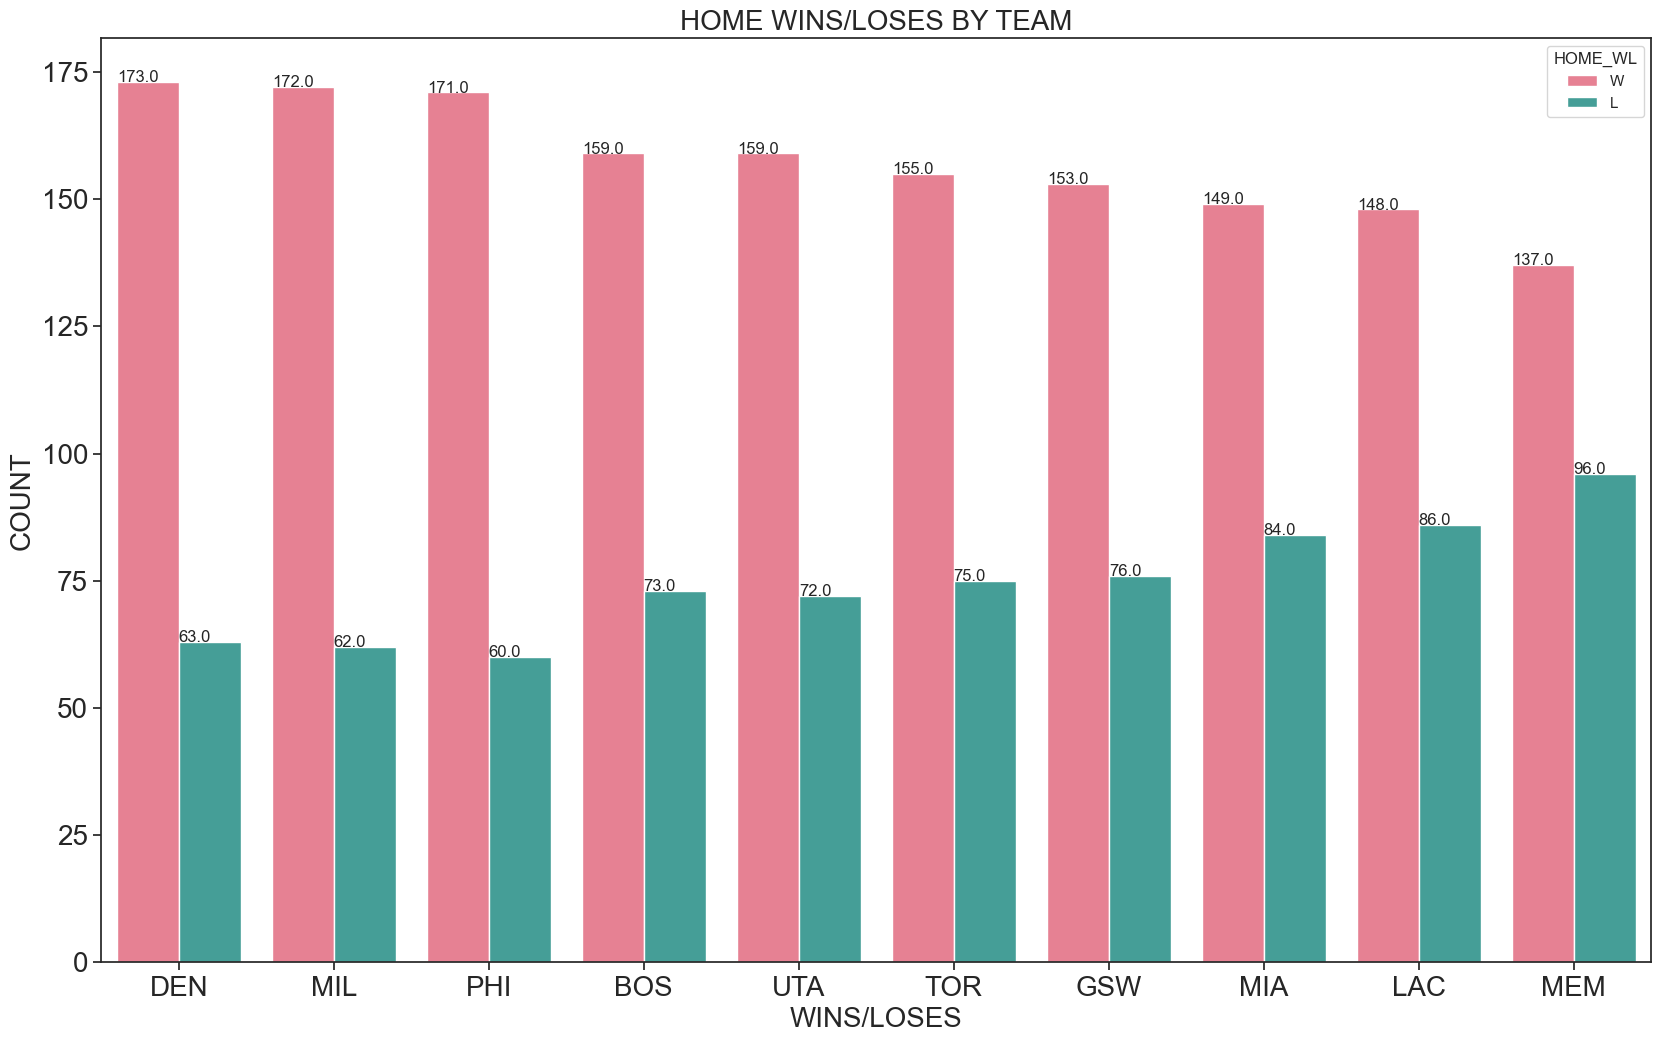

In [685]:
# TEAMS PER HOME WINS/LOSSES BAR PLOT

plt.figure(figsize=(20,12))
fig11 = sns.countplot(data=nba_data, x=nba_data['HOME_TEAM_ABBREVIATION'],
                        palette = 'husl', 
                        hue = nba_data['HOME_WL'],
                        order=nba_data[nba_data['HOME_WL'] == 'W']['HOME_TEAM_ABBREVIATION'].value_counts().iloc[:10].index
                        )
fig11.set_xlabel('WINS/LOSES', fontsize=20)
fig11.set_ylabel('COUNT', fontsize=20)
fig11.tick_params(labelsize=20)
plt.title('HOME WINS/LOSES BY TEAM', fontsize = 20)
for p in fig11.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig11.text(txt_x,txt_y,txt)
plt.show()

Também foram plotadas as vitórias e derrotas dos 10 times com melhor performance em jogos fora de casa nas últimas 6 temporadas apenas para termos uma visualização inicial dos nossos dados. 

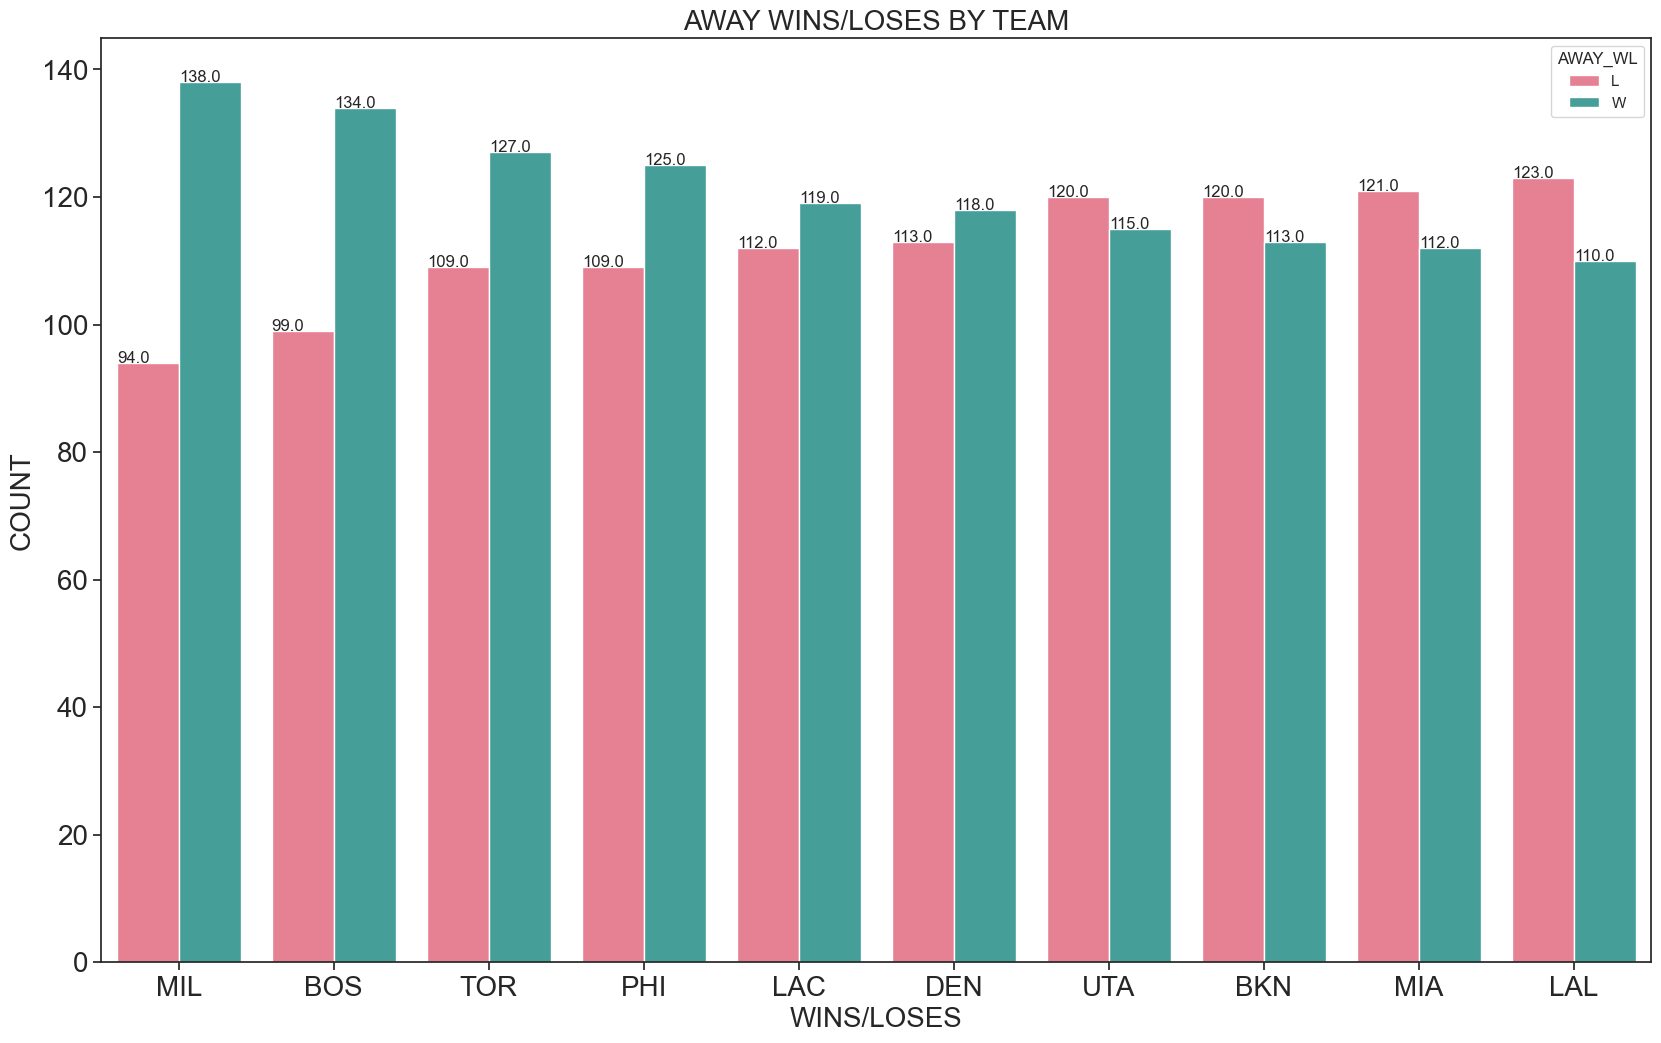

In [686]:
# TEAMS PER AWAY WINS/LOSSES BAR PLOT

plt.figure(figsize=(20,12))
fig2 = sns.countplot(data=nba_data, x=nba_data['AWAY_TEAM_ABBREVIATION'],
                        palette = 'husl', 
                        hue = nba_data['AWAY_WL'],
                        order=nba_data[nba_data['AWAY_WL'] == 'W']['AWAY_TEAM_ABBREVIATION'].value_counts().iloc[:10].index
                        )
fig2.set_xlabel('WINS/LOSES', fontsize=20)
fig2.set_ylabel('COUNT', fontsize=20)
fig2.tick_params(labelsize=20)
plt.title('AWAY WINS/LOSES BY TEAM', fontsize = 20)
for p in fig2.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig2.text(txt_x,txt_y,txt)
plt.show()

Analisando os dois gráficos, percebe-se que o fator casa é valioso na NBA. Times tendem a ter melhores resultados quando jogam em seus domínios.

Um novo dataframe, den_home_data, foi criado a partir de um subconjunto de dados formado por todas as partidas em casa do time Denver Nuggets. Denver foi o time com melhor rendimento em casa no período em análise e é o atual campeão da NBA, sagrandro-se campeão da temproada 2022-23.  Então, vamos checá-lo em maior detalhe.

In [687]:
den_home_data = nba_data[nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN']
den_home_data.head()

,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_GAME_ID,HOME_MATCHUP,HOME_SEASON,HOME_GAME_N,HOME_WL,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,AWAY_GAME_ID,...,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y,GAME_DATE_y,SEASON_y,GAME_N_y,COMPARE_y
27,1610612743,DEN,22200422,DEN vs. WAS,2022-23,27,W,1610612764,WAS,22200422,...,5,12,7,25,23,25,2022-12-12-2022_23,2022-23,29,29-1610612764-2022-23
107,1610612743,DEN,22100411,DEN vs. WAS,2021-22,27,W,1610612764,WAS,22100411,...,11,8,8,6,23,22,2021-12-11-2021_22,2021-22,28,28-1610612764-2021-22
190,1610612743,DEN,22000502,DEN vs. WAS,2020-21,32,L,1610612764,WAS,22000502,...,30,11,30,1,9,25,2021-02-23-2020_21,2020-21,30,30-1610612764-2020-21
246,1610612743,DEN,21900252,DEN vs. WAS,2019-20,16,W,1610612764,WAS,21900252,...,24,23,17,28,2,16,2019-11-24-2019_20,2019-20,15,15-1610612764-2019-20
380,1610612743,DEN,21801148,DEN vs. WAS,2018-19,76,L,1610612764,WAS,21801148,...,24,8,14,12,7,25,2019-03-29-2018_19,2018-19,78,78-1610612764-2018-19


Vale mencionar que Denver é o time que joga em maior elevação na liga, sua arena fica a 5280 acima do nível do mar. Apesar de não ser uma elevação tão considerável, seus efeitos são históricamente conhecidos como um ponto de vantagem para o time da cidade. [1] 

# 2. Rendimento em confrontos

Abaixo, temos um gráfico que apresenta o histórico de confrontos dos Nuggets em casa dentro do período de 6 em análise, ordenado de melhor a pior retrospécto. Denver se sai melhor contra o Portland Trailblazaer, perdendo apenas um jogo em 12 disputados.

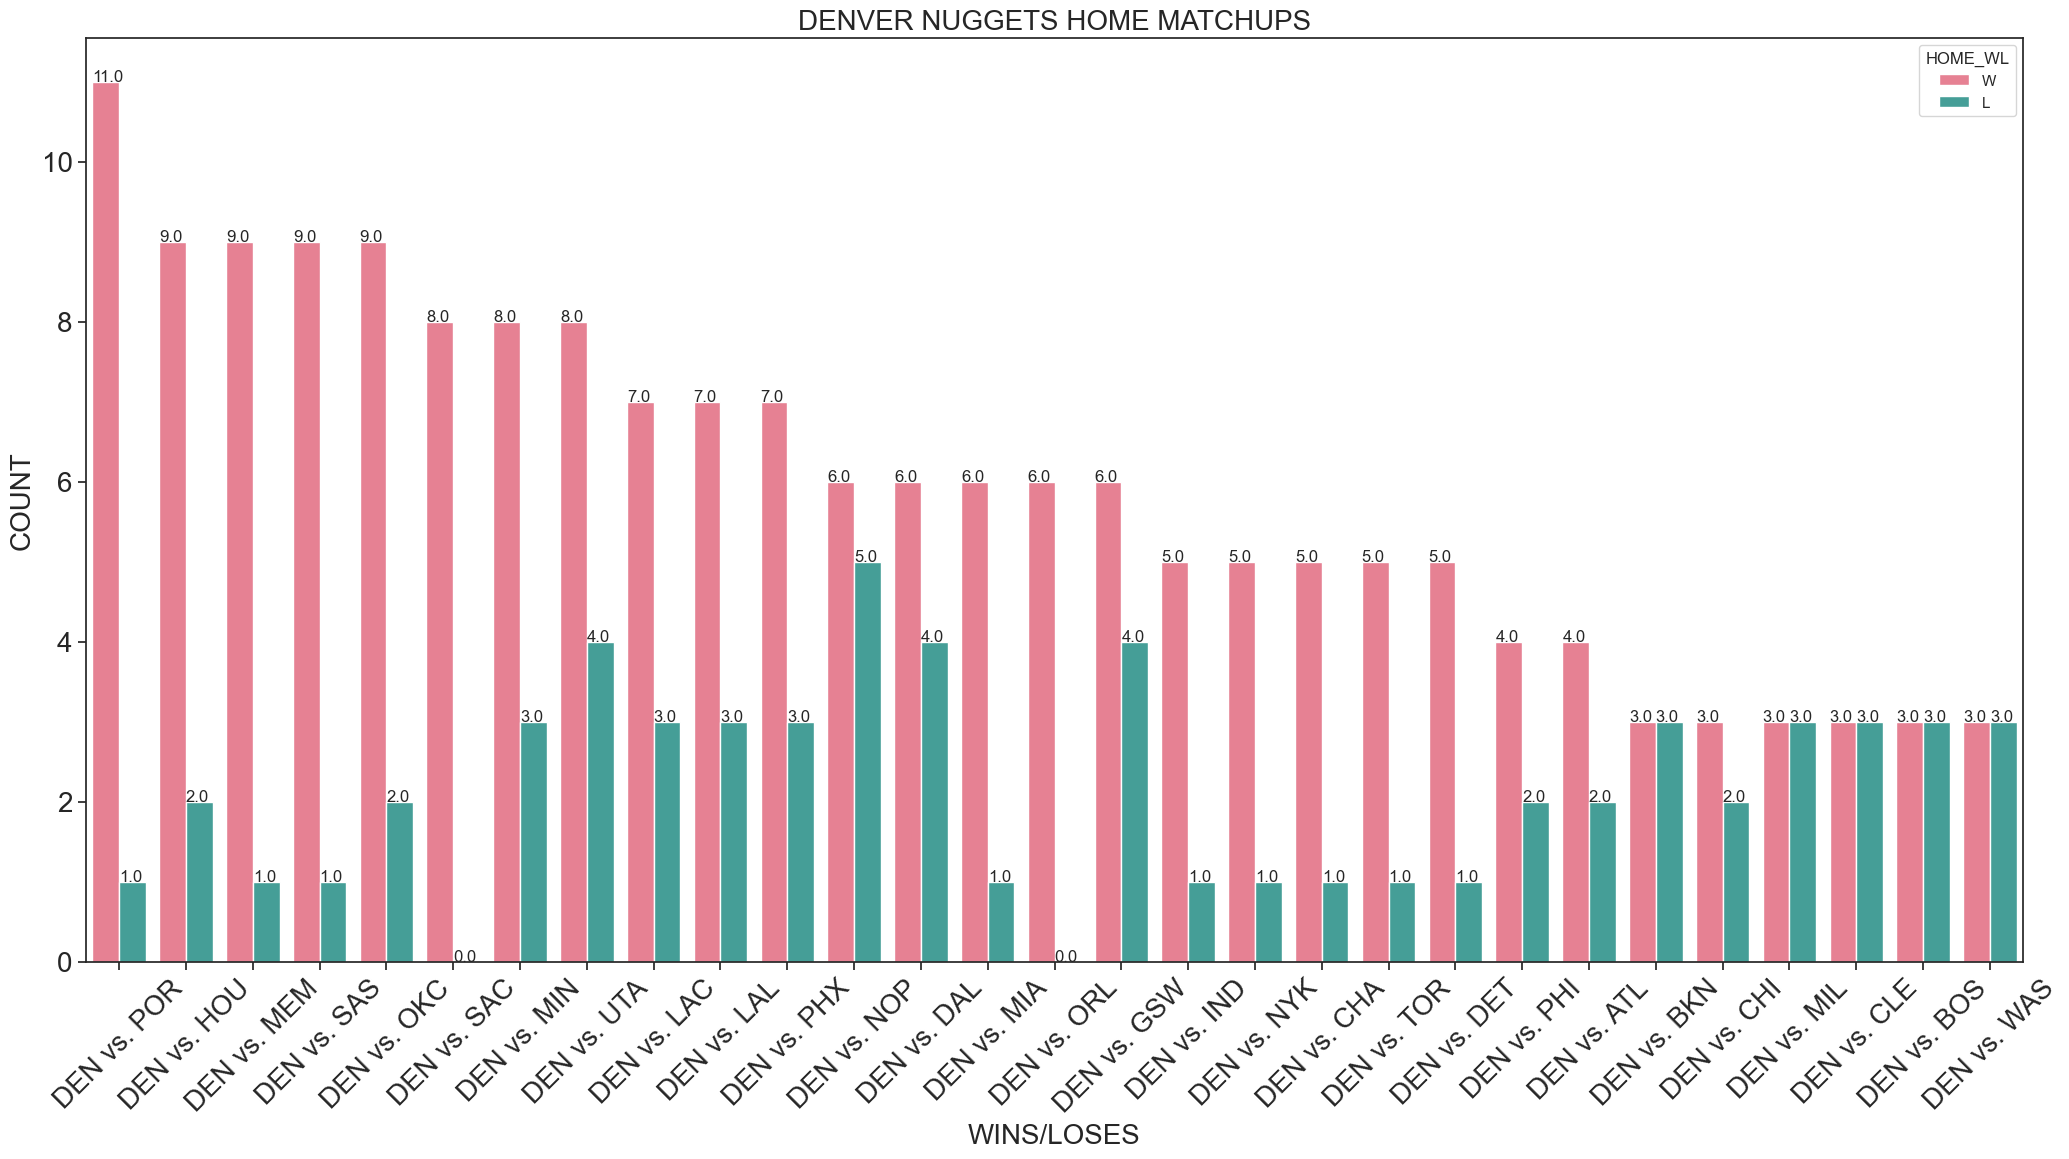

In [688]:
# DENVER NUGGETS HOME MATCHUPS

plt.figure(figsize=(25,12))
fig3 = sns.countplot(data=den_home_data, x=den_home_data['HOME_MATCHUP'],
                        palette = 'husl', 
                        hue = den_home_data['HOME_WL'],
                        order=den_home_data[den_home_data['HOME_WL'] == 'W']['HOME_MATCHUP'].value_counts().index
                        )
fig3.set_xlabel('WINS/LOSES', fontsize=20)
fig3.set_ylabel('COUNT', fontsize=20)
fig3.tick_params(labelsize=20)
plt.title('DENVER NUGGETS HOME MATCHUPS', fontsize = 20)
for p in fig3.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig3.text(txt_x,txt_y,txt)
plt.xticks(rotation=45)
plt.show()

# 3. Avaliação da temporada

Visto que o intuito deste trabalho é prever o vencedor de jogos de NBA utilizandoos dados das temporadas regulares obtidas, abaixo realizamos um de exercício de comparação entre a porcetagem de vitórias do Denver Nuggets ao longo da temporada 2022-23 e alguns das principais estatísticas que temos à disposição.

Porém, analisemos primeiro o quarto gráfico. Ele apresenta a distribuição de vitórias em casa contra os jogos da temporada, como também traça a reta ajustada. Este gráfico nos mostra como Denver possui bom rendimento quando é mandante, pontos quase que traçam uma reta, nos dizendo assim, que Denver venceu praticamente todos os jogos em casa.

Os outros 3 gráficos possuem como eixo x as partidas jogadas em casa. O primeiro, nossa fonte de comparação, apresenta o rendimento do time através da média do percentual de vitórias na temporada até dada partida. O segundo, a média de lances livres tentados por partida na temporada até dada partida. Já o terceiro, a média da porcentagem de arremessos convertidos na temporada até dada partida. 

Como pode-se notar, existe similaridade nas curvas. Tal fato corrobora o esperado, as duas estatísticas apresentadas são historicamente reconhecidas como bons medidores da capacidade de um time em vencer partidas. O lance livre, conhecido também como o arremesso mais fácil do esporte, é a forma mais garantida de pontuar-se no basquete, na temporada 2022-23 por exemplo, a média da liga foi de 78,2% de acerto. Em contra partida, a média para arremesso (cestas) certas ficou em 47,5%. De forma geral, são considerados bons números, que costumam indicar boas chances de vitórias, a partir de 80% para lances livres e 50% para arremessos. [2]

Na temporada 2022-23, Denver terminou com 75,1% para lances livres, sendo a quinta pior média entre todos os times e 50.4% para arremessos, a melhor marca da liga. Entretando, os Nuggets terminam a temporada regular com apenas a quarta posição no ranking geral. Para nos contextualizarmos melhor, vale uma breve explicação de como a temporada regular da NBA opera. [3]

De forma simplificada, temos 30 times que são dividios em 2 grupos (conferências) de 15 times cada, os 8 clubes com melhor ranking dentro de cada conferência se classificam para a pós-temporada, que funciona como um torneiro mata-mata, assim como a segunda fase de uma Copa do Mundo de futebol.

Denver joga na conferência Oeste, os 3 times que terminaram a sua frente jogam na leste. Denver termina a temproada regular liderando a sua conferência, se classificando em primeiro para os playoffs. Se analizarmos o recorte de meio de temporada, Denver chega ao ponto médio com a melhor campanha de sua conferência, com 6 vitórias a mais que o segundo colocado, grande vantagem para a NBA. Já na segunda metade, tem apenas a oitava melhor campanha dentro da conferência. Olhando para a liga como um todo, na primeira metade, termina em terceiro geral, com apenas uma vitória atrás dos líderes, na segunda metade, possui apenas a décima quinta melhor campanha. [4]

Logo percebe-se que a queda de rendimento dos Nuggets ao fim da temporada, perceptível nos gráfico foi resultado de uma escolha do clube em poupar seus atletas, a fim chegar na pós temporada com o time o mais descansado e saudável possível, depois que notou-se que o primeiro lugar na conferência muito dificilmente seria perdido. 

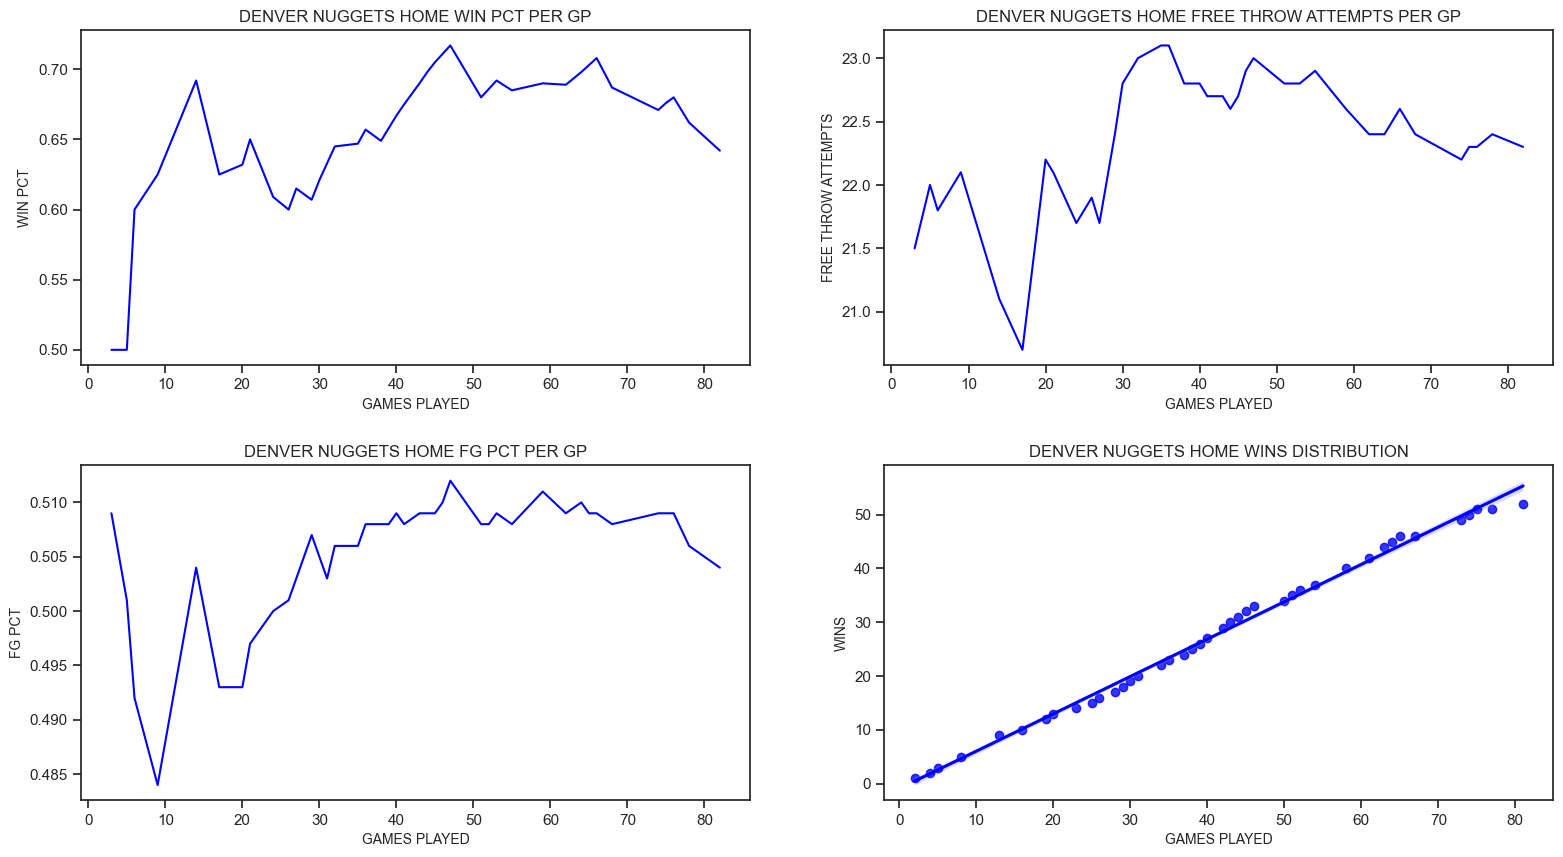

<Figure size 1500x1200 with 0 Axes>

In [689]:
# DENVER HOME GAMES PLOT

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(19, 10))

sns.set_theme(style="ticks")

x4 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['GP_x']
y4 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['W_x']

plt.figure(figsize=(15,12))
fig4 = sns.regplot(
                    x=x4,
                    y=y4,
                    color='blue',
                    ax=ax4
                    )
fig4.set_xlabel('GAMES PLAYED', fontsize=10)
fig4.set_ylabel('WINS', fontsize=10)
ax4.set_title('DENVER NUGGETS HOME WINS DISTRIBUTION', fontsize = 12)

x5 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['W_PCT_x']
y5 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['HOME_GAME_N']

fig5 = sns.lineplot(
                    x=y5,
                    y=x5,
                    color='blue',
                    ax = ax1
                    )
                    
fig5.set_xlabel('GAMES PLAYED', fontsize=10)
fig5.set_ylabel('WIN PCT', fontsize=10)
ax1.set_title('DENVER NUGGETS HOME WIN PCT PER GP', fontsize = 12)

x6 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['FTA_x']
y6 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['HOME_GAME_N']

fig6 = sns.lineplot(
                    x=y6,
                    y=x6,
                    color='blue',
                    ax=ax2
                    )
fig6.set_xlabel('GAMES PLAYED', fontsize=10)
fig6.set_ylabel('FREE THROW ATTEMPTS', fontsize=10)
ax2.set_title('DENVER NUGGETS HOME FREE THROW ATTEMPTS PER GP', fontsize = 12)

x7 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['FG_PCT_x']
y7 = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['HOME_GAME_N']

fig7 = sns.lineplot(
                    x=y7,
                    y=x7,
                    color='blue',
                    ax=ax3
                    )
fig7.set_xlabel('GAMES PLAYED', fontsize=10)
fig7.set_ylabel('FG PCT', fontsize=10)
ax3.set_title('DENVER NUGGETS HOME FG PCT PER GP', fontsize = 12)

fig.subplots_adjust(hspace = 0.3)

Para o próximo bloco de análise analizaremos um dos datasets utilizado para formar o conjunto final de dados deste trabalho. Esta base é a saída do script get_games.py já apresentado. Ela contém a lista de jogos de cada time nas últimas 6 temproadas regulares da NBA. No entanto, continuaremos focando no escopo do Denver Nuggets na temporada 2022-23.

In [690]:
# Read Denver Nuggets data from excel file

denver_games_data = pd.read_excel('games_list_Regular+Season.xlsx')

Os dois blocos abaixo apresentam a comparação da performance dos Nuggets entre vitórias e derrotas para 4 métricas relevantes na análise de times de basquete, elas são:

* Percentual de arremessos certos;
* Lances livres convertidos;
* Arremessos de três pontos convertidos;
* Rebotes.

Dos 20 atributos numéricos presentes no dataset, os listados acima são alguns dos comumente usados na avaliação de times de basquete.

O primeiro bloco trás os comparativos entre vitórias e derrotas na forma de gráficos de barra. O comportamento apresenta-se bastante claro, todas as métricas possuem médias maiores nas vitórias, comportamento mais do que esperado. 

Mais interessante é vermos no segundo bloco, formado por gráficos de linha, que apresentam os mesmos atributos, só que agora, através de toda a temporada. As tendências do primeiro bloco também aparecem aqui, as métricas costumam ser maiores em vitórias porém, esta visualização nos permite notar que não existe um recorte limpo que vá ditar o resultado de um jogo. Os gráficos nos apresentam vitórias de Denver com performances abaixo da média nas métricas apresentadas, como também derrotas em que teve-se bons números. Um exemplo são as vitórias em que Denver acertou apenas 4, 5 bolas de três pontos.

Esta inconsistência corrobora a natureza do esporte, o basquete é um esporte muito dinâmico, onde múltiplos fatores podem alterar o resultado de uma partida, em que você não precisa ter os melhores números toda noite, apenas o suficiente para derrotar o seu adversário e no qual existem diferentes estratétias que podem levar a uma vitória.

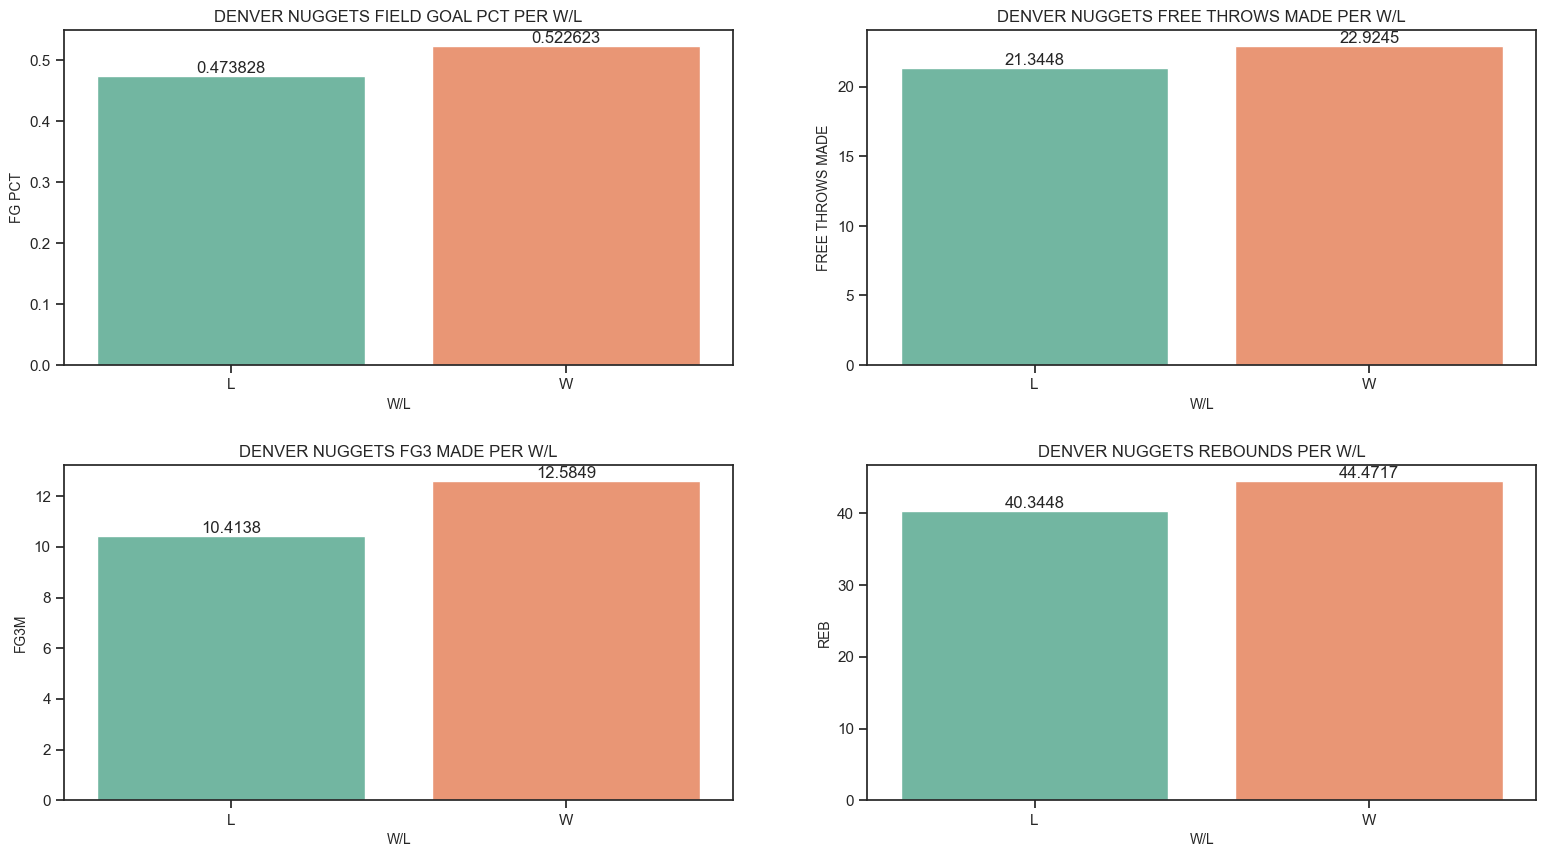

<Figure size 1900x1200 with 0 Axes>

In [691]:
# DENVER GAME BAR PLOTS BY W/L

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(19, 10))

sns.set_theme(style="ticks")

x8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['REB']
y8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

plt.figure(figsize=(19,12))
fig8 = sns.barplot(
                    x=z8,
                    y=x8,
                    palette='Set2',
                    errorbar=None,
                    ax=ax4,
                    )
fig8.set_xlabel('W/L', fontsize=10)
fig8.set_ylabel('REB', fontsize=10)
ax4.set_title('DENVER NUGGETS REBOUNDS PER W/L', fontsize = 12)
for i in fig8.containers:
    fig8.bar_label(i,)


x9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG_PCT']
y9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

fig9 = sns.barplot(
                    x=z9,
                    y=x9,
                    palette='Set2',
                    errorbar=None,
                    ax = ax1
                    )                   
fig9.set_xlabel('W/L', fontsize=10)
fig9.set_ylabel('FG PCT', fontsize=10)
ax1.set_title('DENVER NUGGETS FIELD GOAL PCT PER W/L', fontsize = 12)
for i in fig9.containers:
    fig9.bar_label(i,)

x10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FTA']
y10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

fig10 = sns.barplot(
                    x=z10,
                    y=x10,
                    palette='Set2',
                    errorbar=None,
                    ax=ax2
                    )
fig10.set_xlabel('W/L', fontsize=10)
fig10.set_ylabel('FREE THROWS MADE', fontsize=10)
ax2.set_title('DENVER NUGGETS FREE THROWS MADE PER W/L', fontsize = 12)
for i in fig10.containers:
    fig10.bar_label(i,)

x11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG3M']
y11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

fig11 = sns.barplot(
                    x=z11,
                    y=x11,
                    palette='Set2',
                    errorbar=None,
                    ax=ax3
                    )
fig11.set_xlabel('W/L', fontsize=10)
fig11.set_ylabel('FG3M', fontsize=10)
ax3.set_title('DENVER NUGGETS FG3 MADE PER W/L', fontsize = 12)
for i in fig11.containers:
    fig11.bar_label(i,)

fig.subplots_adjust(hspace = 0.3)

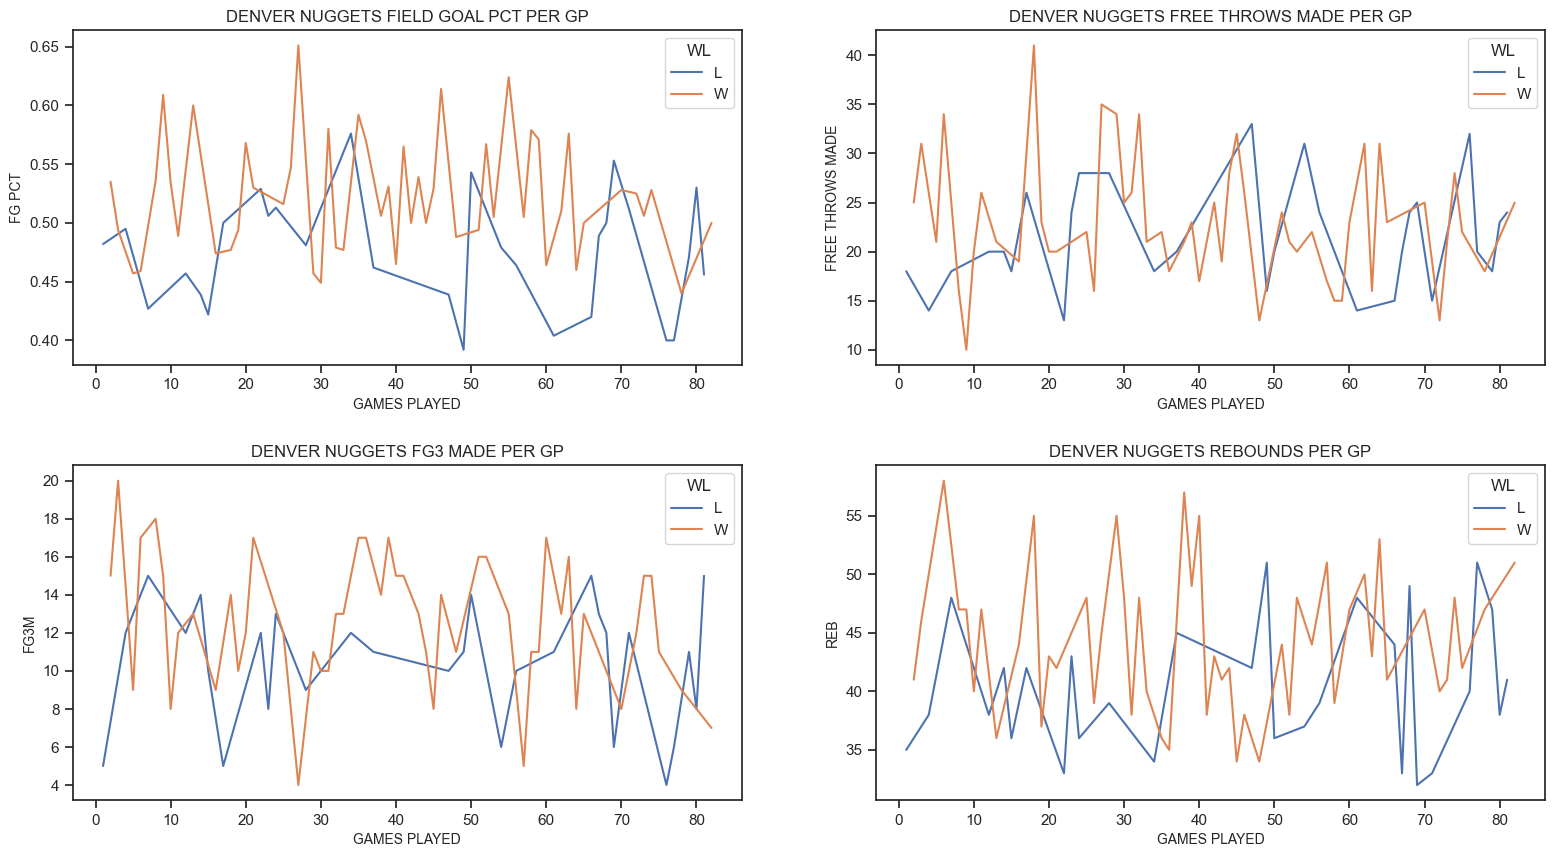

<Figure size 1900x1200 with 0 Axes>

In [692]:
# DENVER GAME LINE PLOTS BY W/L

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(19, 10))

sns.set_theme(style="ticks")

x8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['REB']
y8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

plt.figure(figsize=(19,12))
fig8 = sns.lineplot(
                    x=y8,
                    y=x8,
                    color='red',
                    hue=z8,
                    ax=ax4
                    )
fig8.set_xlabel('GAMES PLAYED', fontsize=10)
fig8.set_ylabel('REB', fontsize=10)
ax4.set_title('DENVER NUGGETS REBOUNDS PER GP', fontsize = 12)


x9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG_PCT']
y9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

fig9 = sns.lineplot(
                    x=y9,
                    y=x9,
                    color='red',
                    hue=z9,
                    ax = ax1
                    )
                    
fig9.set_xlabel('GAMES PLAYED', fontsize=10)
fig9.set_ylabel('FG PCT', fontsize=10)
ax1.set_title('DENVER NUGGETS FIELD GOAL PCT PER GP', fontsize = 12)

x10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FTA']
y10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

fig10 = sns.lineplot(
                    x=y10,
                    y=x10,
                    color='red',
                    hue=z9,
                    ax=ax2
                    )
fig10.set_xlabel('GAMES PLAYED', fontsize=10)
fig10.set_ylabel('FREE THROWS MADE', fontsize=10)
ax2.set_title('DENVER NUGGETS FREE THROWS MADE PER GP', fontsize = 12)

x11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG3M']
y11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['WL']

fig11 = sns.lineplot(
                    x=y11,
                    y=x11,
                    color='red',
                    hue=z11,
                    ax=ax3
                    )
fig11.set_xlabel('GAMES PLAYED', fontsize=10)
fig11.set_ylabel('FG3M', fontsize=10)
ax3.set_title('DENVER NUGGETS FG3 MADE PER GP', fontsize = 12)

fig.subplots_adjust(hspace = 0.3)

Os dois blocos a seguir são bastante semelhantes aos anteriores, porém, estes comparam a performance em casa e fora. Como é de se esperar, nas 4 estatísticas escolhidas para análise, as médias são melhores em casa. Nos jogos em casa Denver arremessa em média 51,5% e fora 49,6%, acerta em média uma bola de três, cerca de 4 lances livres e pega 4 rebotes a mais. Em uma liga tão disputada e onde os jogos são muitas vezes são decididos nos últimos lances, estas alerações fazem muita diferença no reusultado das partidas.

O segundo aponta assim como fez o gráfico de linha para vitórias e derrotas mencionado anteriormente, que não existe de forma consistente um padrão de performance que garente uma vitória. Nós podemos perceber que há jogos em que Denver tem bons números e ganha, outros que tem bons números e perde, outros que tem números inferiores e perde e também jogos que que performa abaixo e ganha. Todos os cenários se apresentam no decorrer da temporada. Como também, como é ocorre muitas vezes, o cenário onde um time performa bem em certos aspectos e não tão bem em outros.

Como já mencionado, no esporte, principamente nos coletivos onde você enfrenta outro time em uma partida, nem sempre precisa-se ter os melhores números, apenas o suficiente para bater o adversário.

Tal comportamento analisado já nos indica que não será trivial criar uma rede neural capaz de prever o resultado de jogos com uma acertividade alta. Nem sempre boas performances resultam em vitórias em um jogo tão complexo e de tantos números;

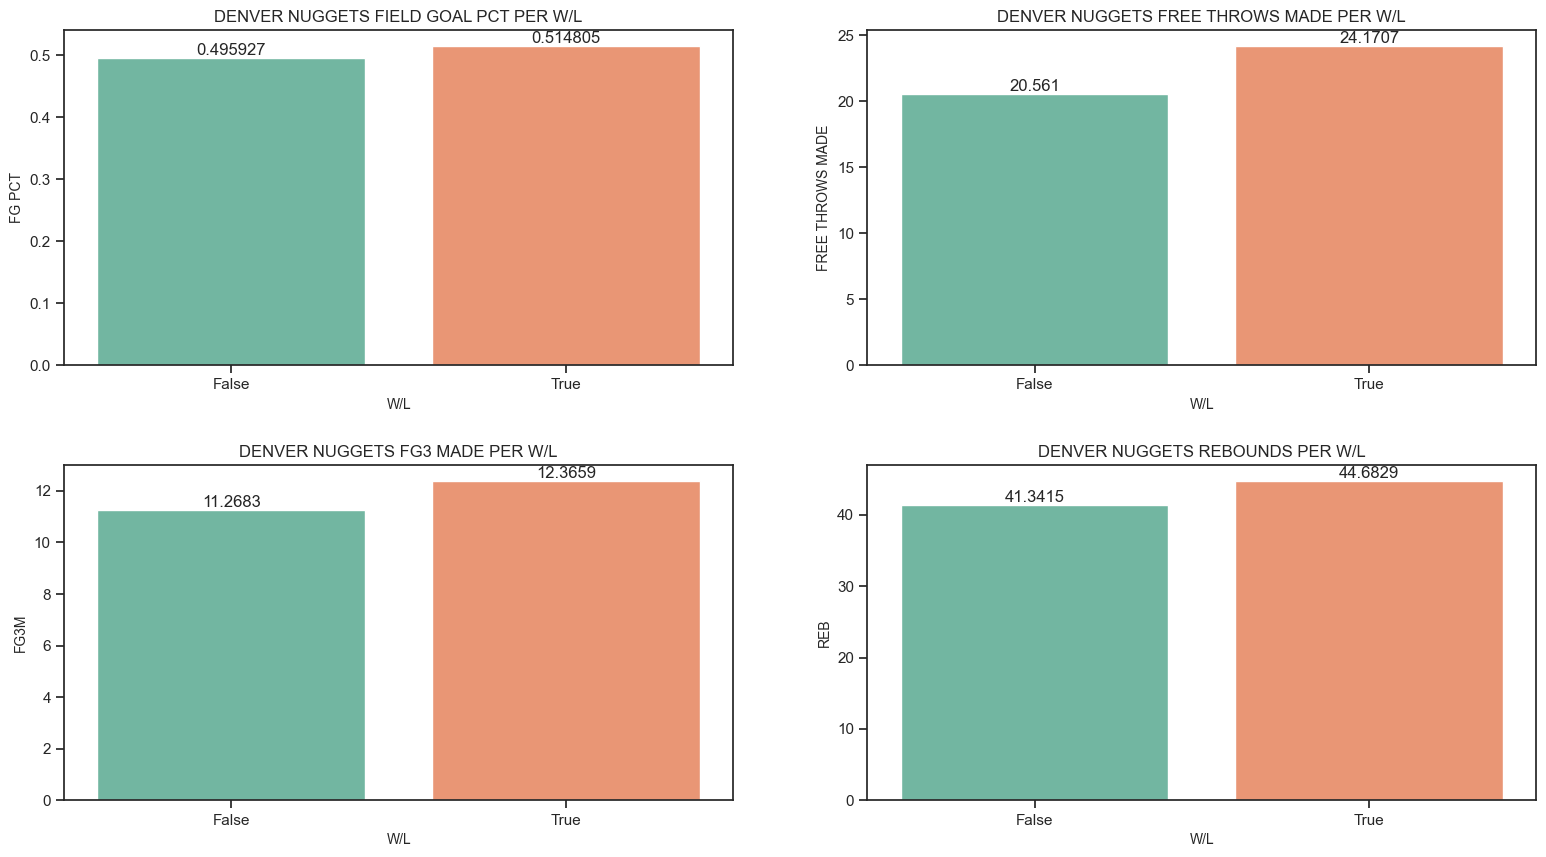

<Figure size 1900x1200 with 0 Axes>

In [693]:
# DENVER GAME BAR PLOTS BY HOME/AWAY

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(19, 10))

sns.set_theme(style="ticks")

x8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['REB']
y8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')
plt.figure(figsize=(19,12))
fig8 = sns.barplot(
                    x=z8,
                    y=x8,
                    palette='Set2',
                    errorbar=None,
                    ax=ax4,
                    )
fig8.set_xlabel('W/L', fontsize=10)
fig8.set_ylabel('REB', fontsize=10)
ax4.set_title('DENVER NUGGETS REBOUNDS PER W/L', fontsize = 12)
for i in fig8.containers:
    fig8.bar_label(i,)


x9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG_PCT']
y9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')
fig9 = sns.barplot(
                    x=z9,
                    y=x9,
                    palette='Set2',
                    errorbar=None,
                    ax = ax1
                    )                   
fig9.set_xlabel('W/L', fontsize=10)
fig9.set_ylabel('FG PCT', fontsize=10)
ax1.set_title('DENVER NUGGETS FIELD GOAL PCT PER W/L', fontsize = 12)
for i in fig9.containers:
    fig9.bar_label(i,)

x10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FTA']
y10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')

fig10 = sns.barplot(
                    x=z10,
                    y=x10,
                    palette='Set2',
                    errorbar=None,
                    ax=ax2
                    )
fig10.set_xlabel('W/L', fontsize=10)
fig10.set_ylabel('FREE THROWS MADE', fontsize=10)
ax2.set_title('DENVER NUGGETS FREE THROWS MADE PER W/L', fontsize = 12)
for i in fig10.containers:
    fig10.bar_label(i,)

x11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG3M']
y11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')

fig11 = sns.barplot(
                    x=z11,
                    y=x11,
                    palette='Set2',
                    errorbar=None,
                    ax=ax3
                    )
fig11.set_xlabel('W/L', fontsize=10)
fig11.set_ylabel('FG3M', fontsize=10)
ax3.set_title('DENVER NUGGETS FG3 MADE PER W/L', fontsize = 12)
for i in fig11.containers:
    fig11.bar_label(i,)

fig.subplots_adjust(hspace = 0.3)

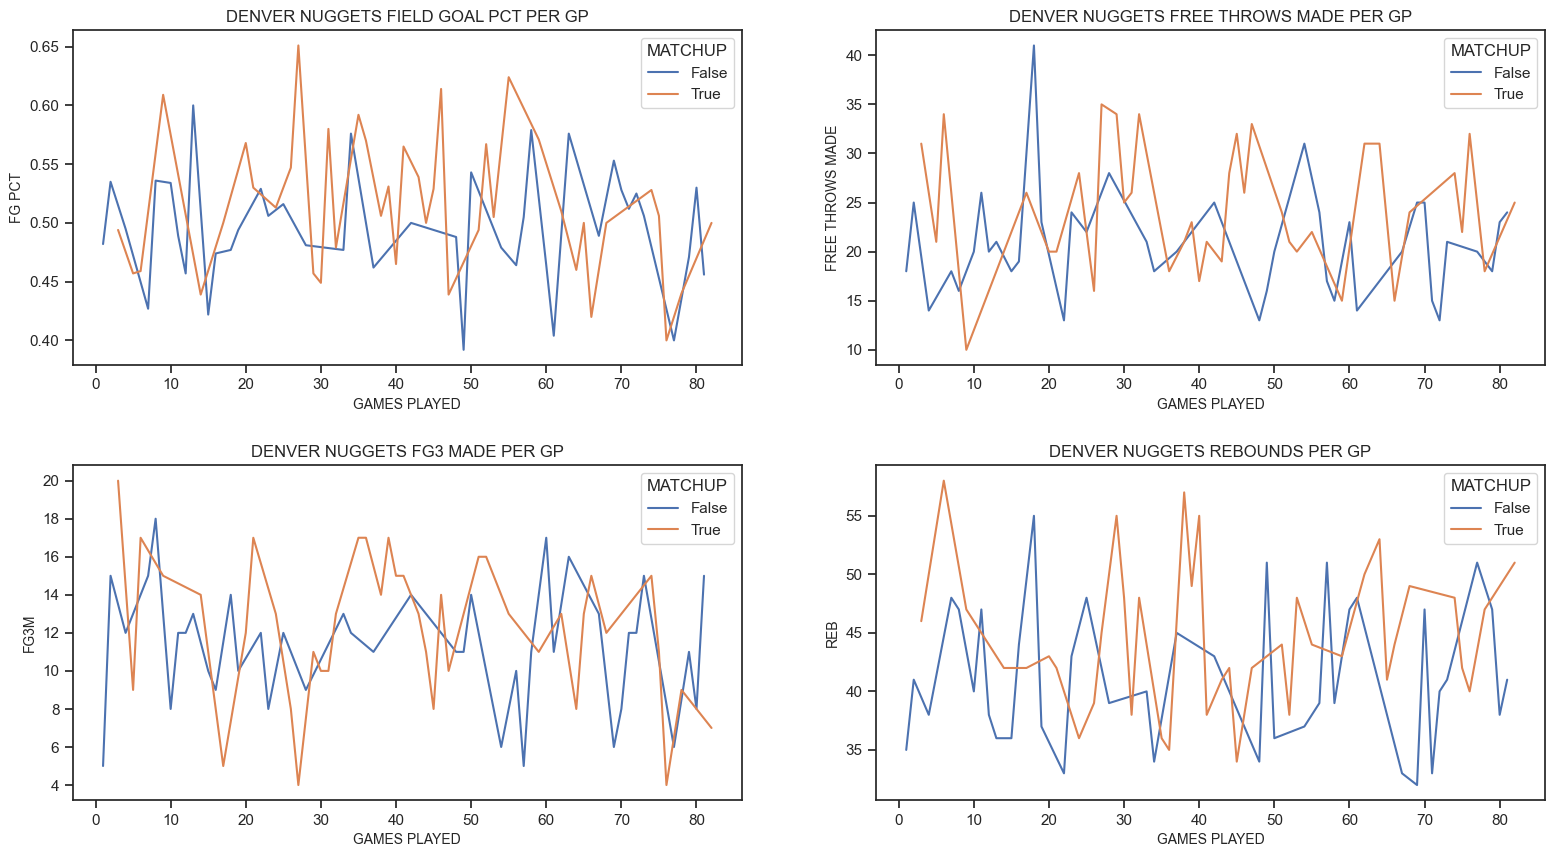

<Figure size 1900x1200 with 0 Axes>

In [694]:
# DENVER GAME LINE PLOTS BY HOME/AWAY

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(19, 10))

sns.set_theme(style="ticks")

x8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['REB']
y8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z8 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')

plt.figure(figsize=(19,12))
fig8 = sns.lineplot(
                    x=y8,
                    y=x8,
                    color='red',
                    hue=z8,
                    ax=ax4
                    )
fig8.set_xlabel('GAMES PLAYED', fontsize=10)
fig8.set_ylabel('REB', fontsize=10)
ax4.set_title('DENVER NUGGETS REBOUNDS PER GP', fontsize = 12)

x9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG_PCT']
y9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z9 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')

fig9 = sns.lineplot(
                    x=y9,
                    y=x9,
                    color='red',
                    hue=z9,
                    ax = ax1
                    )
                    
fig9.set_xlabel('GAMES PLAYED', fontsize=10)
fig9.set_ylabel('FG PCT', fontsize=10)
ax1.set_title('DENVER NUGGETS FIELD GOAL PCT PER GP', fontsize = 12)

x10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FTA']
y10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z10 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')

fig10 = sns.lineplot(
                    x=y10,
                    y=x10,
                    color='red',
                    hue=z9,
                    ax=ax2
                    )
fig10.set_xlabel('GAMES PLAYED', fontsize=10)
fig10.set_ylabel('FREE THROWS MADE', fontsize=10)
ax2.set_title('DENVER NUGGETS FREE THROWS MADE PER GP', fontsize = 12)

x11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['FG3M']
y11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['GAME_N']
z11 = denver_games_data[(denver_games_data['TEAM_ABBREVIATION'] == 'DEN') & (denver_games_data['season_id'] == '2022-23')]['MATCHUP'].str.contains('vs.')

fig11 = sns.lineplot(
                    x=y11,
                    y=x11,
                    color='red',
                    hue=z11,
                    ax=ax3
                    )
fig11.set_xlabel('GAMES PLAYED', fontsize=10)
fig11.set_ylabel('FG3M', fontsize=10)
ax3.set_title('DENVER NUGGETS FG3 MADE PER GP', fontsize = 12)

fig.subplots_adjust(hspace = 0.3)

# Previsão de resultados utilizando Redes Neurais

A partir deste ponto nosso conjunto dce dados foi tratado a fim de alimentar a Rede Neural com o intuito de prever o resultado de jogos.

# Preparo dos Dados

Abaixo serão apresentadas as operaões realizadas no conjunto de dados.

* Redução de dimensão: Atributos categóricos que não contribuem para a previsão dos jogos foram retirados, a maioria categórica e redundante entre si, como por exemplo, atributos que trazem o nome e a abreviação dos times.

    - Segue abaixo a lista completa do 27 atributos retirados:

        - 1.	HOME_TEAM_ID
        - 2.	HOME_TEAM_ABBREVIATION
        - 3.	HOME_GAME_ID
        - 4.	HOME_MATCHUP
        - 5.	HOME_SEASON
        - 6.	HOME_GAME_N
        - 7.	AWAY_TEAM_ID
        - 8.	AWAY_TEAM_ABBREVIATION
        - 9.	AWAY_GAME_ID
        - 10.	AWAY_MATCHUP
        - 11.	AWAY_SEASON
        - 12.	AWAY_GAME_N
        - 13.	AWAY_WL
        - 14.	HOME_COMPARE
        - 15.	AWAY_COMPARE
        - 16.	TEAM_ID_x
        - 17.	TEAM_NAME_x
        - 18.	GAME_DATE_x
        - 19.	SEASON_x
        - 20.	GAME_N_x
        - 21.	COMPARE_x
        - 22.	TEAM_ID_y
        - 23.	TEAM_NAME_y
        - 24.	GAME_DATE_y
        - 25.	SEASON_y
        - 26.	GAME_N_y
        - 27.	COMPARE_y

* Conversão categórico x numérico: Apos a redução de dimensionalidade, apenas um atributo categório permaneceu no conjunto de dados, o que indica o vencedor do confronto. Ele foi convertido de forma que o valor W (vitória) passa a ser 0 e L (derrota) passa a ser 1.

* Divisão treino x teste: Os conjuntos de treino e teste foram criados com os seguintes parâmetros:

    - Razão treino/teste igual a 0,3.
    - Random state igual a 100 para permitir reproducibilidade dos conjuntos de treino e teste.
    - Estratificação ativada para permitir uma divisão equilibrada entre os resultados do sub conjunto de dados escolhido.

* Variância: Checagem de atributos com variância igual a zero. Nenhum atributo foi encontrado.

* Normalização: Os dados das bases de Treino e Teste foram normalizados. É uma etapa fundamental pois o conjunto de dados possui atributos numéricos em ordens de grandeza diferentes, como por exmplo 'W_PCT_x' e 'FGA_x'. Esta diferença pode levar os modelos a uma menor eficiência.

In [695]:
# Drop Columns

nba_data.drop(nba_data.columns[[0,1,2,3,4,5,7,8,9,10,11,12,13,14,
                                  15,16,17,70,71,72,73,74,75,128,129,130,131]], axis=1, inplace=True)

nba_data.to_excel('test_table.xlsx')

In [696]:
# Turn categorical column HOME_WL into numerial

nba_data['HOME_WL'] = nba_data['HOME_WL'].apply(lambda x: 0 if x == 'W' else 1)
nba_data.head()

,HOME_WL,GP_x,W_x,L_x,W_PCT_x,MIN_x,FGM_x,FGA_x,FG_PCT_x,FG3M_x,...,REB_RANK_y,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y
0,0,1,1,0,1.000,48.0,42.0,92.0,0.457,11.0,...,12,15,14,2,6,2,25,8,8,7
1,0,2,1,1,0.500,48.0,43.0,81.0,0.531,13.0,...,10,17,24,21,2,7,7,27,18,9
2,0,3,2,1,0.667,49.7,42.0,86.3,0.486,11.0,...,8,9,9,14,28,30,10,7,17,27
3,1,4,3,1,0.750,49.3,42.5,86.0,0.494,10.8,...,9,7,16,26,3,21,23,17,11,25
4,0,5,3,2,0.600,49.0,41.6,86.0,0.484,15.2,...,24,14,23,21,5,7,19,23,20,11


In [697]:
# Separate database in train and test

X = nba_data.loc[:, nba_data.columns != 'HOME_WL']
y = nba_data['HOME_WL']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.3, 
                                                    random_state = 100, 
                                                    stratify = y,
                                                    )

In [698]:
# Check columns with variance equal to zero and drop them

zero_var_filter = VarianceThreshold()
X_train = zero_var_filter.fit_transform(X_train)
X_test = zero_var_filter.transform(X_test)
print('X_train e X_test possuíam', (zero_var_filter.variances_ == 0).sum(), 'atributo(s) com variância igual a zero \n')

#print(zero_var_filter.variances_ == 0, '\n')

X_train e X_test possuíam 0 atributo(s) com variância igual a zero 



In [699]:
# Normalize data

preprocessParams = preprocessing.StandardScaler().fit(X_train)
X_train_normalized = preprocessParams.transform(X_train)
X_test_normalized = preprocessParams.transform(X_test)

X_train_normalized

array([[-0.19390183, -0.51290067,  0.17945249, ..., -0.17228294,
        -0.60944706,  0.07584392],
       [-1.61094241, -1.43070805, -1.36273462, ...,  1.22296558,
         0.88705677,  1.1184542 ],
       [-1.21239975, -1.43070805, -0.66875042, ...,  0.06025848,
        -1.18502546, -1.19845753],
       ...,
       [ 0.95744365,  0.94029435,  0.71921797, ..., -1.21871934,
        -1.06990978,  1.00260862],
       [ 0.69174854,  1.47568199, -0.28320365, ...,  0.87415345,
         1.46263517,  0.53922627],
       [-1.38952982, -1.12477225, -1.28562526, ..., -1.21871934,
         0.19636269, -1.31430312]])

Os conjuntos de Treino e Teste do conjunto de partidas ficaram com os seguintes formatos:

In [700]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (4874, 104)
X_test: (2089, 104)
y_train: (4874,)
y_test: (2089,)


# Rede Neural

A rede neural abaixo foi criada utilizando a biblioteca Tensorflow. A rede neural criada é do tipo densa, redes do tipo densa são aquelas que suas camadas são profundamente conectadas à camada anterior, ou seja, cada neurônio da camada está ligado a todos os neurônios da camada anterior. O nosso modelo treinado também é do tipo supervisionado. O processo de aprendizado supervisionado é aquele em que tem-se os dados de entrada e o(s) valores de sáida conhecido(s) utilizados para treinar o modelo, a rede.

In [701]:
# Train Neural Network

NumberOfClasses = len(y_train.unique())
NumberOfClasses

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
print(y_train)

[0 0 0 ... 1 0 1]


Após os testes com diferentes formatos, obtvemos melhores resultados com uma configuração de 4 camadas, a de entrada, duas intermediárias e a de saída. Para todas as camadas a função de ativação sigmoid obteve os melhores resutados. A rede, com a sua quantide de parâmetros, pode ser vista abaixo:

In [702]:
# Neural Network

RN = Sequential()
RN.add(Dense(25,input_shape = X_train_normalized.shape[1:], activation = 'sigmoid'))
RN.add(Dense(12,activation = 'sigmoid'))
RN.add(Dense(5,activation = 'sigmoid'))
RN.add(Dense(NumberOfClasses, activation = 'sigmoid'))
RN.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 25)                2625      
                                                                 
 dense_102 (Dense)           (None, 12)                312       
                                                                 
 dense_103 (Dense)           (None, 5)                 65        
                                                                 
 dense_104 (Dense)           (None, 2)                 12        
                                                                 
Total params: 3014 (11.77 KB)
Trainable params: 3014 (11.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


A rede foi treinada utilizando um callback como early stop que terminava o treinamento no momento que alcançava-se 65% de acurácia. Nos testes, 65% foi por volta do melhor valor obtido antes de notarmos o crescimento da perda no treinamento, caracterista da ocorrência de Overfitting na rede.

In [703]:
# Training

accuracy_threshold = 0.68

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}) :
        if(logs.get('accuracy') is not None and logs.get('accuracy') >= accuracy_threshold) :
            print('\nReached 65.0% accuracy.')
            self.model.stop_training = True

callbacks = myCallback()

RN.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy']) 
history = RN.fit(X_train_normalized, to_categorical(y_train), epochs = 1280, 
                    batch_size=128, validation_split=0.3, callbacks = [callbacks])

Epoch 1/1280


27/27 [==============================] - 1s 7ms/step - loss: 0.7473 - accuracy: 0.4298 - val_loss: 0.7391 - val_accuracy: 0.4463
Epoch 2/1280
27/27 [==============================] - 0s 2ms/step - loss: 0.7358 - accuracy: 0.4298 - val_loss: 0.7293 - val_accuracy: 0.4463
Epoch 3/1280
27/27 [==============================] - 0s 2ms/step - loss: 0.7263 - accuracy: 0.4298 - val_loss: 0.7213 - val_accuracy: 0.4463
Epoch 4/1280
27/27 [==============================] - 0s 2ms/step - loss: 0.7185 - accuracy: 0.4298 - val_loss: 0.7148 - val_accuracy: 0.4443
Epoch 5/1280
27/27 [==============================] - 0s 2ms/step - loss: 0.7121 - accuracy: 0.4667 - val_loss: 0.7095 - val_accuracy: 0.5079
Epoch 6/1280
27/27 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5635 - val_loss: 0.7052 - val_accuracy: 0.5516
Epoch 7/1280
27/27 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5714 - val_loss: 0.7018 - val_accuracy: 0.5537
Epoch 8/1280
27/27 

In [704]:
# Evaluation

score = RN.evaluate(X_test_normalized, to_categorical(y_test), verbose = 0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

Test loss score: 0.640436589717865
Test accuracy: 0.6443274021148682


In [705]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


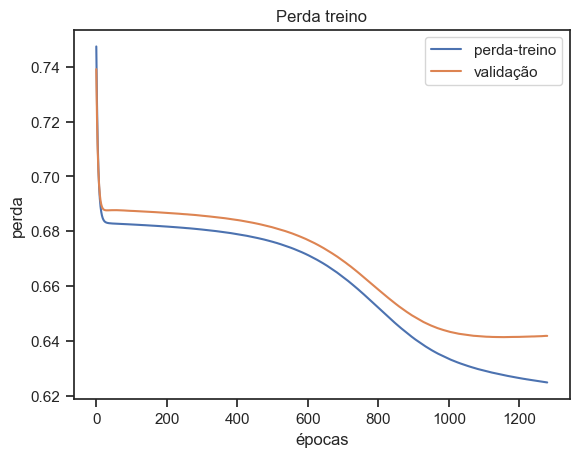

In [706]:
# Training chart: Training and validation per loss and epochs

plt.plot(history.history['loss'], label='perda-treino')
plt.plot(history.history['val_loss'], label='validação')
#plt.plot(history.history['accuracy'], label='acurácia-treino')
#plt.plot(history.history['val_accuracy'], label='acurácia-validação')
plt.title('Perda treino')
plt.ylabel('perda')
plt.xlabel('épocas')
plt.legend()

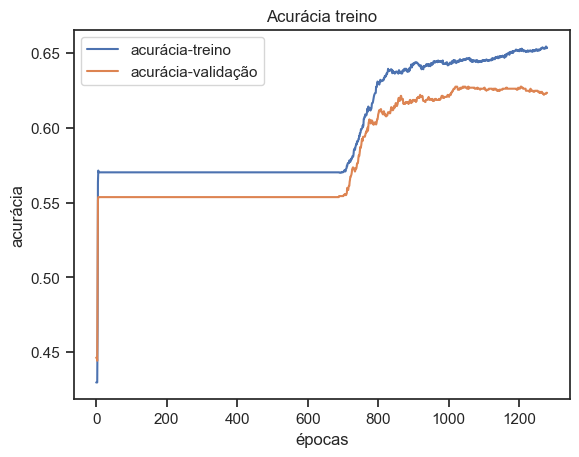

In [707]:
# Training chart: Training and validation per acuracy and epochs

#plt.plot(history.history['loss'], label='perda-treino')
#plt.plot(history.history['val_loss'], label='validação')
plt.plot(history.history['accuracy'], label='acurácia-treino')
plt.plot(history.history['val_accuracy'], label='acurácia-validação')
plt.title('Acurácia treino')
plt.ylabel('acurácia')
plt.xlabel('épocas')
plt.legend()

# REFERÊNCIAS

1 https://english.elpais.com/sports/2023-06-03/mile-high-nba-advantage-denver-altitude-helps-nuggets-go-unbeaten-at-home-in-playoffs.html

2 https://www.basketball-reference.com/leagues/NBA_stats_per_game.html

3 https://www.nba.com/stats/teams/traditional

4 https://www.nba.com/stats/teams/traditional?Conference=West&SeasonSegment=Pre+All-Star